# import packadges

Working version of code: https://www.kaggle.com/code/daniil19189/creating-preprocessed-data-set

In [14]:
import numpy as np
import pandas as pd
from functools import cache
from typing import Literal
import matplotlib.pyplot as plt
import mne

import keras_cv
import keras
from keras import ops
import tensorflow as tf

import os
import glob
from pathlib import Path

import pywt
import torch

# Data import

In [15]:
path = '/kaggle/input/hms-harmful-brain-activity-classification'

def load_eeg(eeg_id, data_type:Literal['train','test']='train'):
    eeg_df = pd.read_parquet(f'{path}/{data_type}_eegs/{eeg_id}.parquet')
    return eeg_df

In [16]:
# Load the training data from a CSV file
train_df = pd.read_csv(f'{path}/train.csv')
train_df

eeg_id  eeg_sub_id  eeg_label_offset_seconds  spectrogram_id  \
0       1628180742           0                       0.0          353733   
1       1628180742           1                       6.0          353733   
2       1628180742           2                       8.0          353733   
3       1628180742           3                      18.0          353733   
4       1628180742           4                      24.0          353733   
...            ...         ...                       ...             ...   
106795   351917269           6                      12.0      2147388374   
106796   351917269           7                      14.0      2147388374   
106797   351917269           8                      16.0      2147388374   
106798   351917269           9                      18.0      2147388374   
106799   351917269          10                      20.0      2147388374   

        spectrogram_sub_id  spectrogram_label_offset_seconds    label_id  \
0                        0                               0.0   127492639   
1                        1                               6.0  3887563113   
2                        2                               8.0  1142670488   
3                        3                              18.0  2718991173   
4                        4                              24.0  3080632009   
...                    ...                               ...         ...   
106795                   6                              12.0  4195677307   
106796                   7                              14.0   290896675   
106797                   8                              16.0   461435451   
106798                   9                              18.0  3786213131   
106799                  10                              20.0  3642716176   

        patient_id expert_consensus  seizure_vote  lpd_vote  gpd_vote  \
0            42516          Seizure             3         0         0   
1            42516          Seizure             3         0         0   
2            42516          Seizure             3         0         0   
3            42516          Seizure             3         0         0   
4            42516          Seizure             3         0         0   
...            ...              ...           ...       ...       ...   
106795       10351             LRDA             0         0         0   
106796       10351             LRDA             0         0         0   
106797       10351             LRDA             0         0         0   
106798       10351             LRDA             0         0         0   
106799       10351             LRDA             0         0         0   

        lrda_vote  grda_vote  other_vote  
0               0          0           0  
1               0          0           0  
2               0          0           0  
3               0          0           0  
4               0          0           0  
...           ...        ...         ...  
106795          3          0           0  
106796          3          0           0  
106797          3          0           0  
106798          3          0           0  
106799          3          0           0  

[106800 rows x 15 columns]

In [17]:
# Load EEG data for the first entry in the training DataFrame
eeg_df = load_eeg(train_df.iloc[0,0])
eeg_df


Fp1          F3          C3          P3          F7          T3  \
0      -80.519997  -70.540001  -80.110001 -108.750000 -120.330002  -88.620003   
1      -80.449997  -70.330002  -81.760002 -107.669998 -120.769997  -90.820000   
2      -80.209999  -75.870003  -82.050003 -106.010002 -117.500000  -87.489998   
3      -84.709999  -75.339996  -87.480003 -108.970001 -121.410004  -94.750000   
4      -90.570000  -80.790001  -93.000000 -113.870003 -129.960007 -102.860001   
...           ...         ...         ...         ...         ...         ...   
17995 -144.660004 -147.809998 -129.820007 -129.460007 -157.509995 -124.000000   
17996 -140.880005 -153.000000 -129.529999 -129.020004 -154.059998 -131.220001   
17997 -133.729996 -141.770004 -121.900002 -122.370003 -158.750000 -123.550003   
17998 -141.449997 -151.139999 -127.190002 -128.699997 -163.460007 -124.309998   
17999 -138.669998 -147.210007 -122.820000 -128.289993 -164.869995 -124.239998   

               T5          O1          Fz          Cz         Pz         Fp2  \
0     -101.750000 -104.489998  -99.129997  -90.389999 -97.040001  -77.989998   
1     -104.260002  -99.730003  -99.070000  -92.290001 -96.019997  -84.500000   
2      -99.589996  -96.820000 -119.680000  -99.360001 -91.110001  -99.440002   
3     -105.370003 -100.279999 -113.839996 -102.059998 -95.040001  -99.230003   
4     -118.599998 -101.099998 -107.660004 -102.339996 -98.510002  -95.300003   
...           ...         ...         ...         ...        ...         ...   
17995 -124.570000  -94.820000 -153.070007 -121.110001 -86.459999 -132.520004   
17996 -128.380005  -95.000000 -140.820007 -114.639999 -84.379997 -115.339996   
17997 -127.730003  -93.089996 -125.230003 -106.489998 -83.419998 -112.720001   
17998 -129.479996  -94.419998 -140.869995 -113.339996 -83.519997 -129.300003   
17999 -129.339996  -95.320000 -136.789993 -112.820000 -84.660004 -129.380005   

               F4          C4          P4          F8         T4          T6  \
0      -88.830002 -112.120003 -108.110001  -95.949997 -98.360001 -121.730003   
1      -84.989998 -115.610001 -103.860001  -97.470001 -89.290001 -115.500000   
2     -104.589996 -127.529999 -113.349998  -95.870003 -96.019997 -123.879997   
3     -101.220001 -125.769997 -111.889999  -97.459999 -97.180000 -128.940002   
4      -88.930000 -115.639999  -99.800003  -97.500000 -88.730003 -114.849998   
...           ...         ...         ...         ...        ...         ...   
17995 -138.339996 -128.970001  -71.300003 -114.480003 -86.709999 -114.959999   
17996 -119.230003 -114.709999  -70.989998  -92.129997 -79.639999 -116.139999   
17997 -103.209999 -107.629997  -61.869999  -97.910004 -77.150002 -106.500000   
17998 -118.650002 -117.589996  -71.879997  -99.279999 -83.900002 -116.160004   
17999 -123.180000 -122.889999  -79.910004 -101.459999 -84.339996 -125.989998   

               O2        EKG  
0     -106.449997   7.920000  
1     -102.059998  29.219999  
2     -105.790001  45.740002  
3     -109.889999  83.870003  
4     -100.250000  97.769997  
...           ...        ...  
17995  -81.500000 -20.070000  
17996  -81.879997  10.600000  
17997  -75.339996  -2.060000  
17998  -81.410004   2.820000  
17999  -89.110001  35.279999  

[18000 rows x 20 columns]

Creating RawArray with float64 data, n_channels=20, n_times=18000
    Range : 0 ... 17999 =      0.000 ...    89.995 secs
Ready.


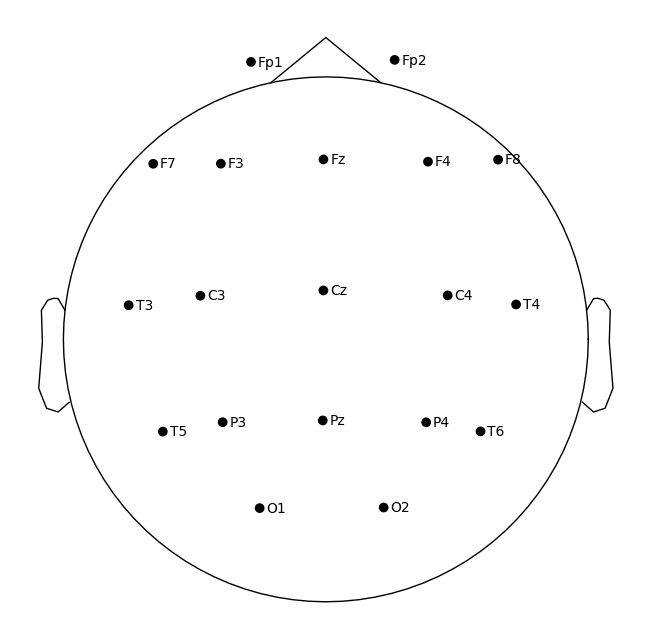

Using matplotlib as 2D backend.


<Figure size 640x480 with 0 Axes>

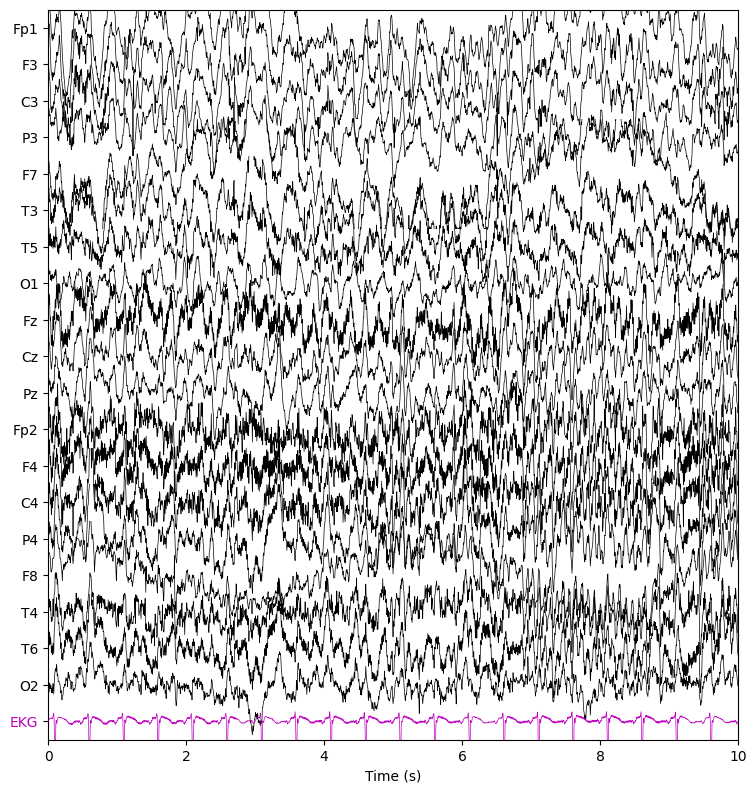

<Figure size 640x480 with 0 Axes>

In [24]:
# Create an MNE info object to store metadata about the EEG data
info = mne.create_info(
    eeg_df.columns.to_list(), # List of channel names
    ch_types=(["eeg"]*(len(eeg_df.columns)-1))+['ecg'], # Channel types, mostly EEG with one ECG
    sfreq=200 # Sampling frequency
)

# Set the montage to the standard 10-20 system
info.set_montage("standard_1020")

# Transpose the EEG data values and scale them
data_values = eeg_df.values.T
raw = mne.io.RawArray(data_values*1e-6, info)

# Plot the sensor layout with channel names
raw.plot_sensors(show_names=True)
plt.tight_layout()

# Plot the raw data for viewing and cleaning
raw.plot(show_scrollbars=False, show_scalebars=False)
plt.tight_layout()

Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json


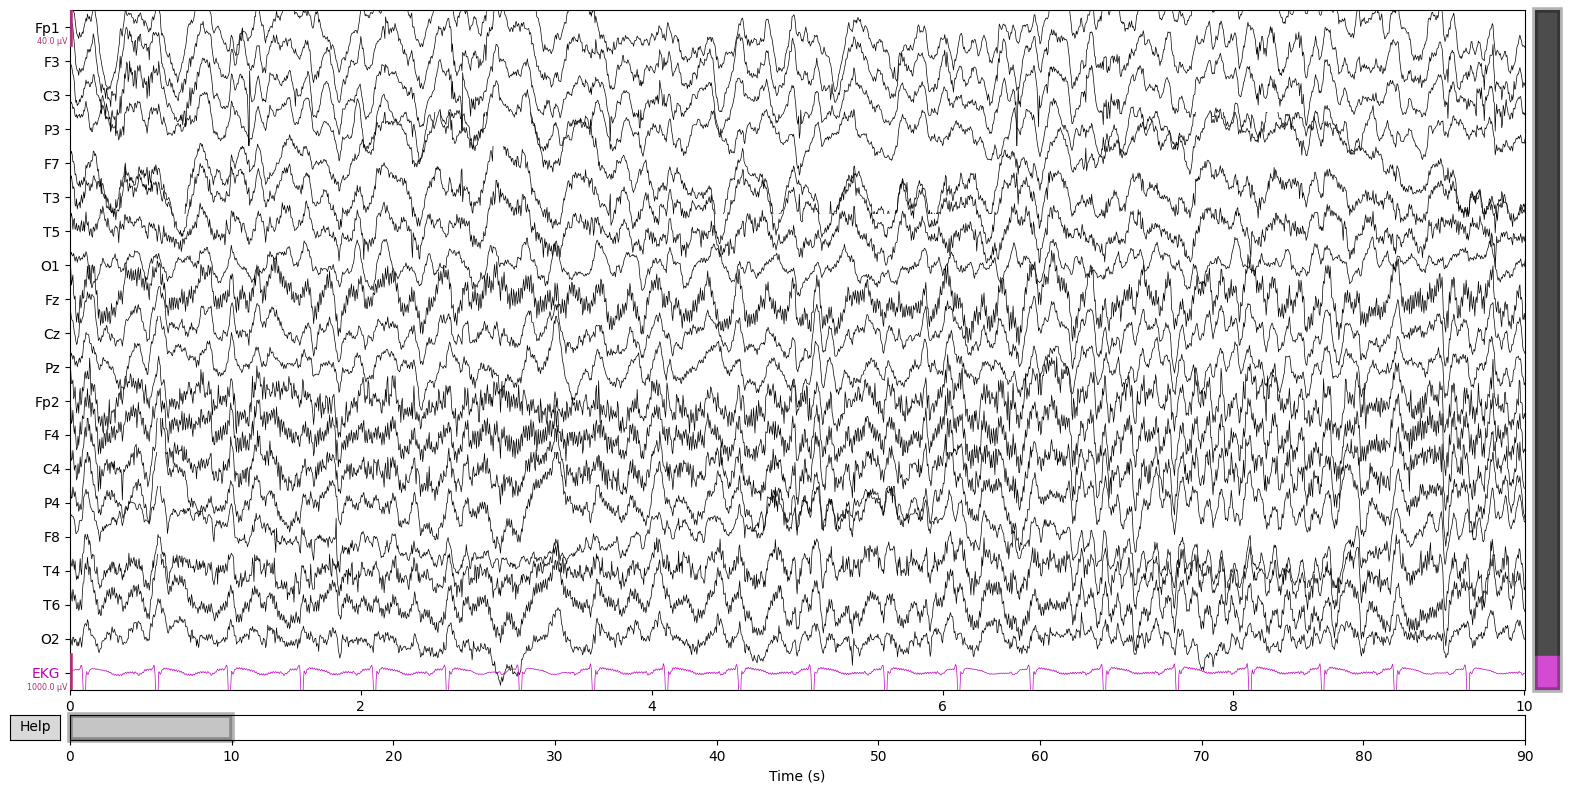

In [25]:
# Set the configuration for the raw data plot size
mne.set_config('MNE_BROWSE_RAW_SIZE','16,8')
# Plot the raw data with scrollbars and scalebars hidden
raw.plot() # Use start= and duration= parameters to scroll through the data
plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1321 samples (6.605 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband ed

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


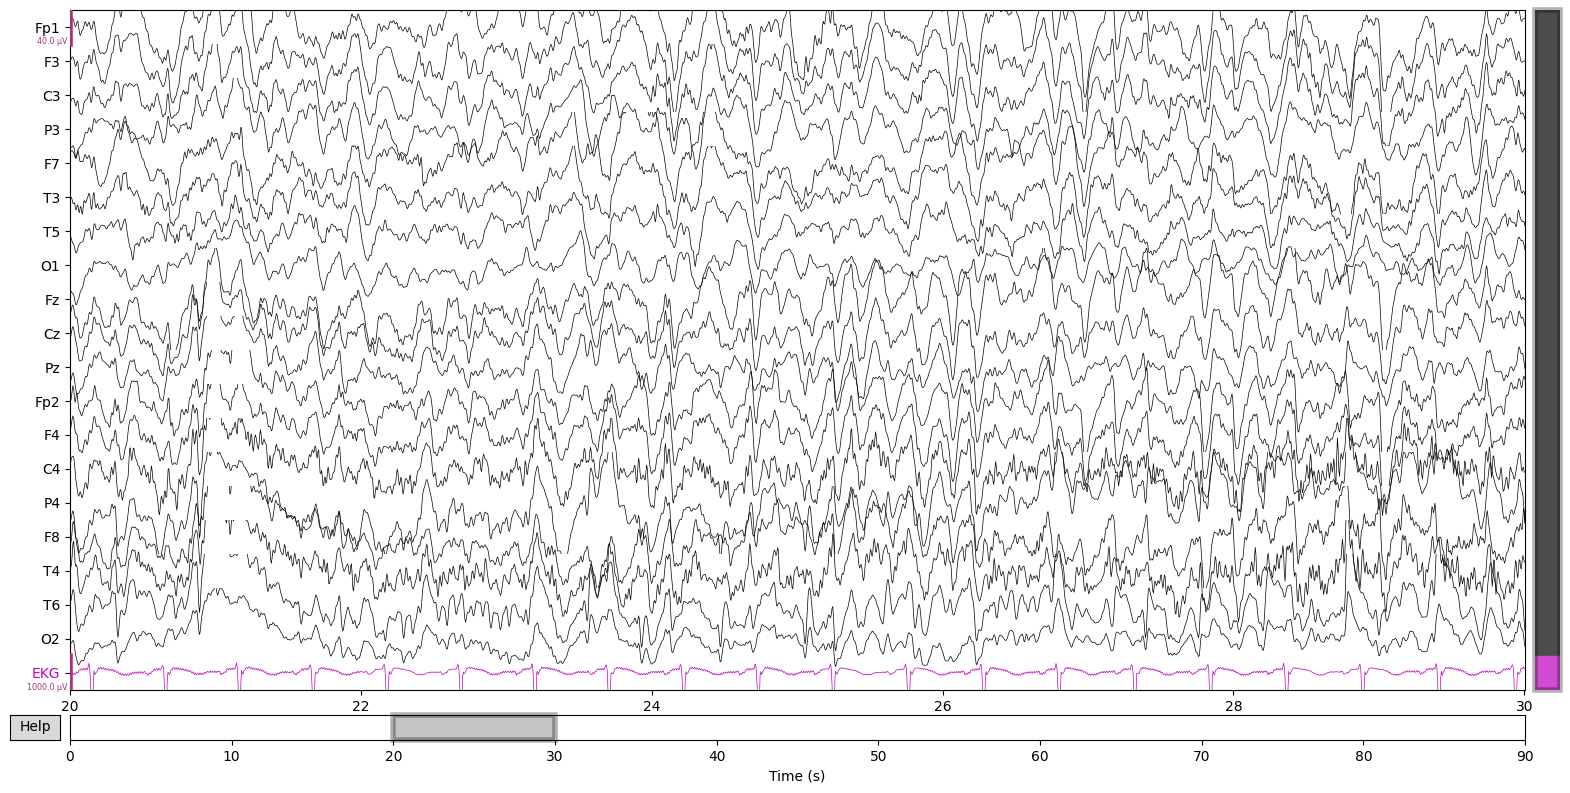

In [26]:
# Apply a notch filter at 50 Hz and a band-pass filter between 0.1 and 45 Hz
raw_filtered = raw.notch_filter(50).filter(0.1, 45)
# Plot the filtered data starting at 20 seconds, with a 10-second window
raw_filtered.plot(start=20, duration=10)
plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 661 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


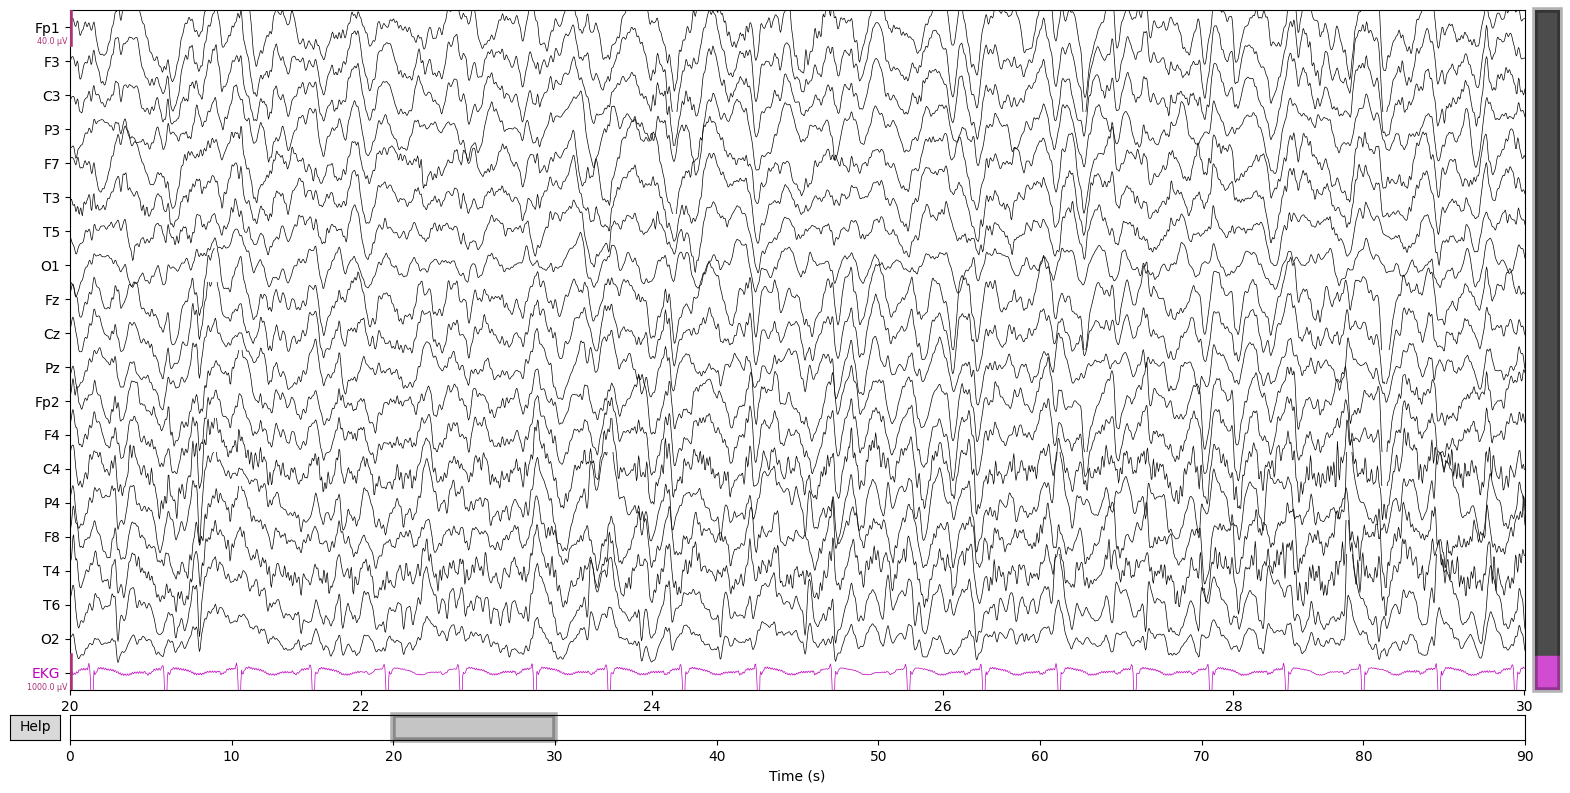

In [27]:
# Copy the raw data, then apply a band-pass filter between 1 and 70 Hz and a notch filter at 60 Hz for EEG channels
raw_filtered = raw.copy().filter(l_freq=1, h_freq=70,).notch_filter(60, picks='eeg')
# Plot the newly filtered data starting at 20 seconds, with a 10-second window
raw_filtered.plot(start=20, duration=10)
plt.show()

In [28]:
# Perform ICA (Independent Component Analysis) with 95% of the variance explained
ica = mne.preprocessing.ICA(n_components=0.95)
ica.fit(raw)

Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by explained variance: 9 components
Fitting ICA took 0.5s.


<ICA | raw data decomposition, method: fastica (fit in 28 iterations on 18000 samples), 9 ICA components (19 PCA components available), channel types: eeg, no sources marked for exclusion>

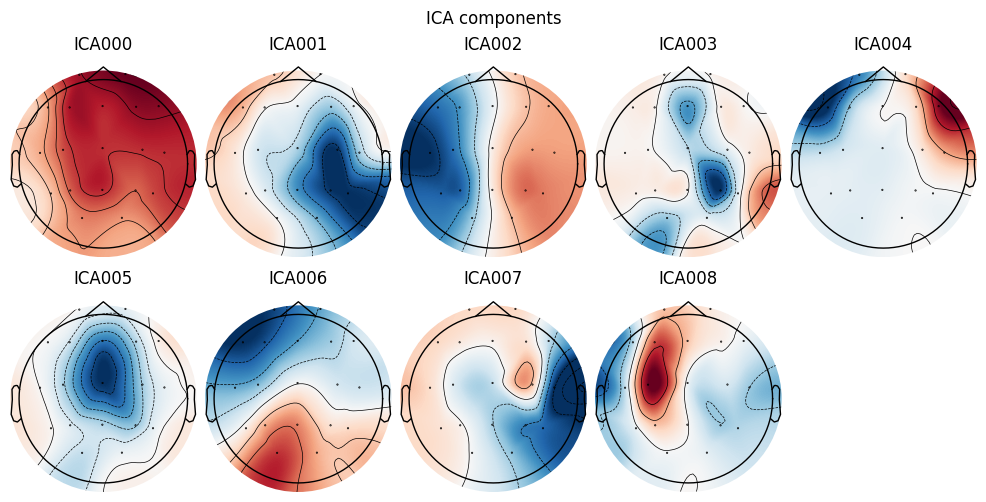

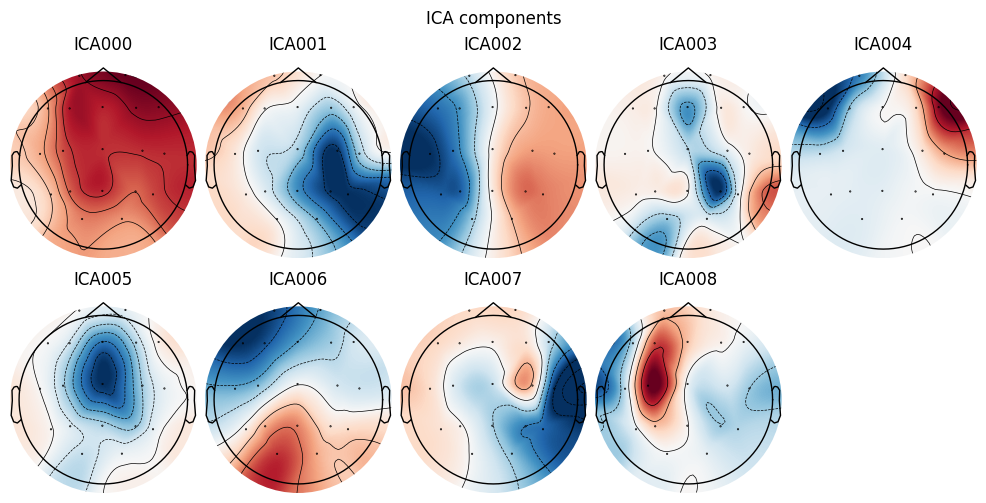

In [29]:
# Plot the ICA components (several times for some reason)
ica.plot_components()

Creating RawArray with float64 data, n_channels=10, n_times=18000
    Range : 0 ... 17999 =      0.000 ...    89.995 secs
Ready.


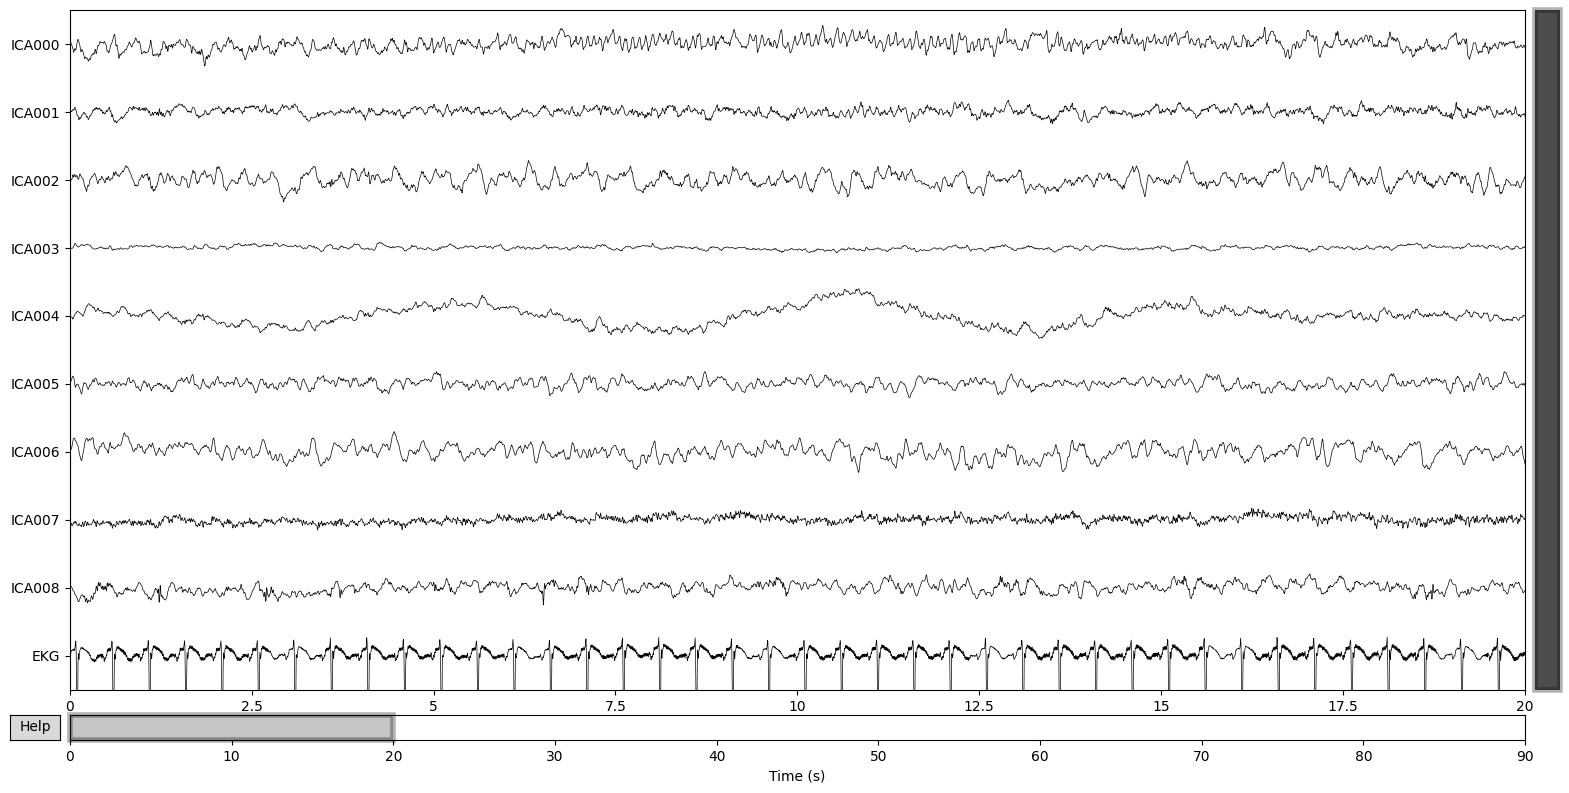

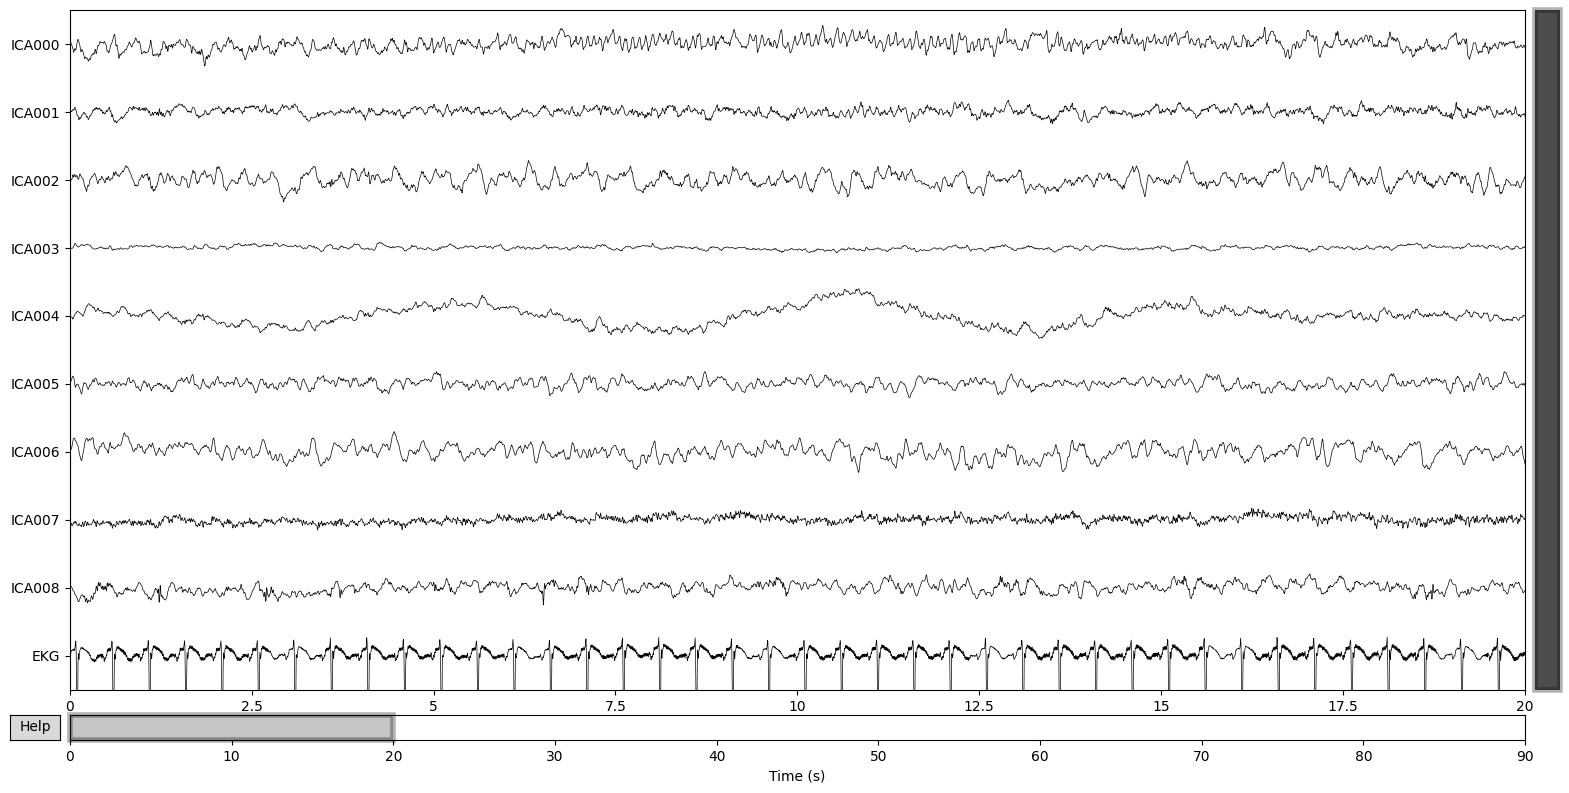

In [32]:
# Plot the sources identified by ICA
ica.plot_sources(raw) 

Applying ICA to Raw instance
    Transforming to ICA space (9 components)
    Zeroing out 0 ICA components
    Projecting back using 19 PCA components


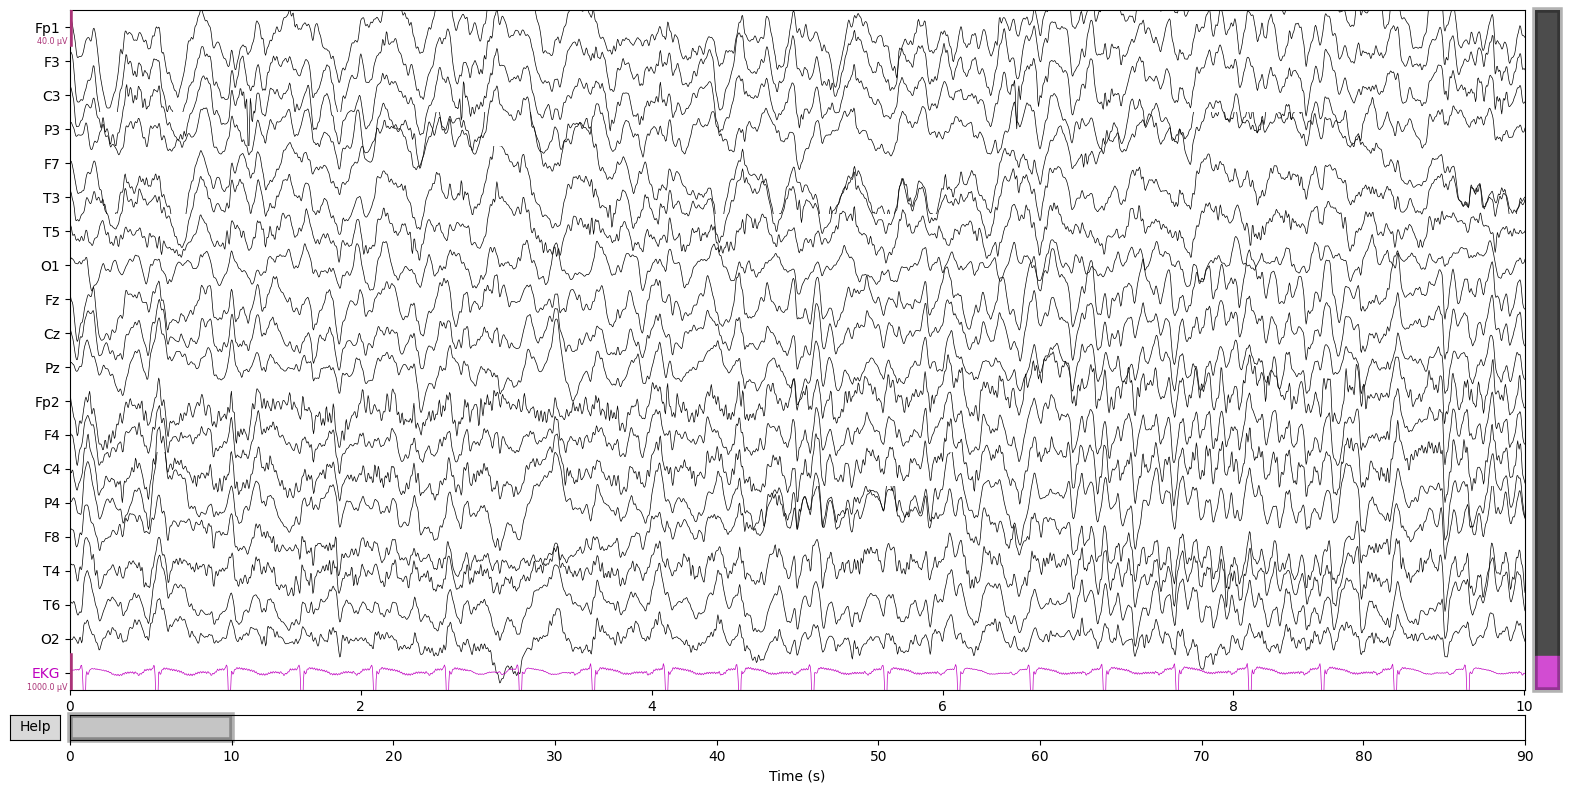

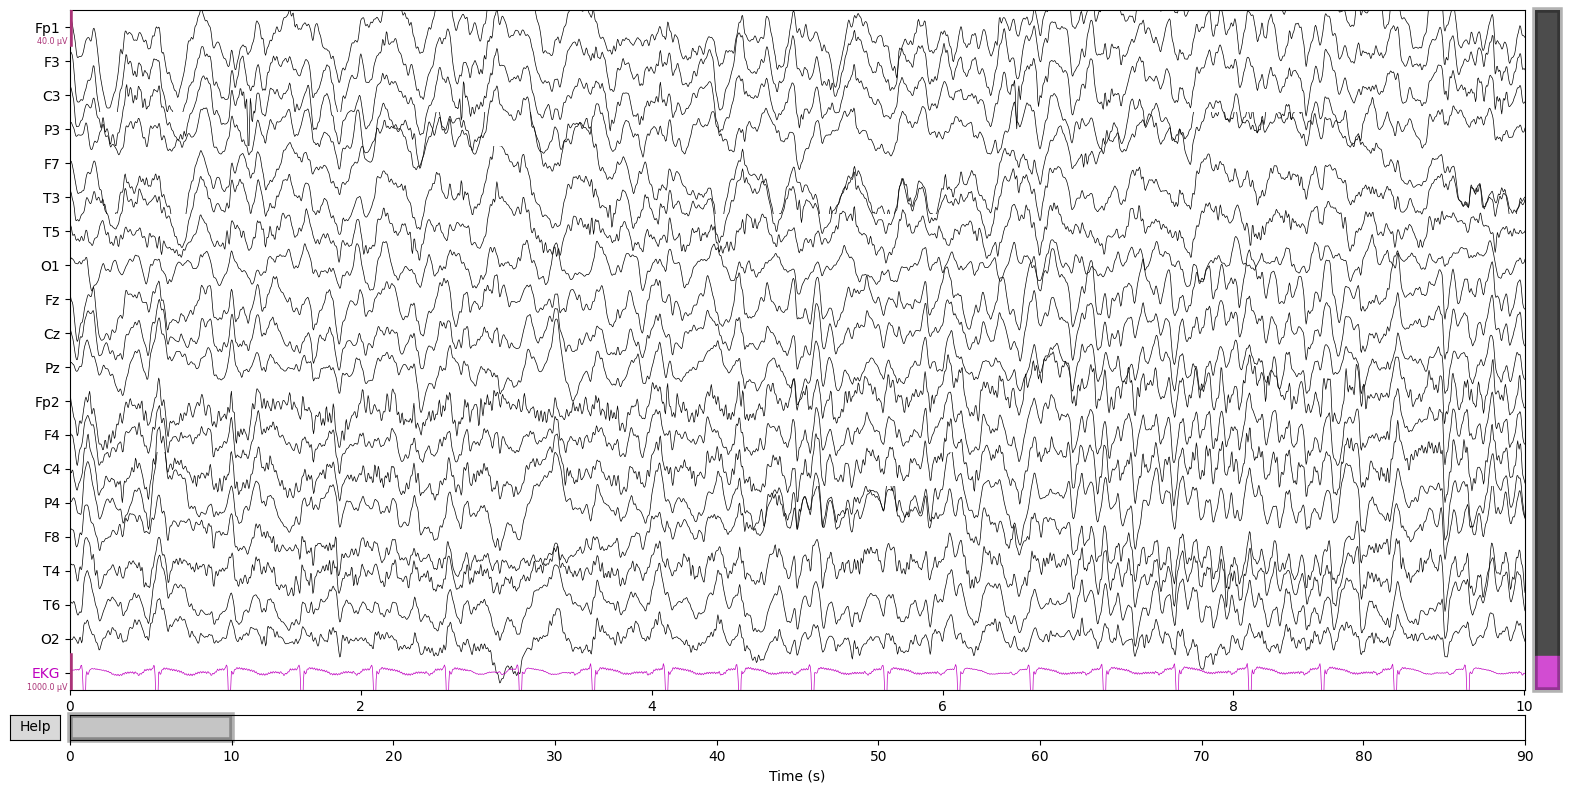

In [33]:
# Create a copy of the raw data to apply ICA exclusion
raw_reconstructed = raw.copy()
ica.exclude = [4,'EKG']  # Exclude component 4 and the EKG channel
ica.apply(raw_reconstructed)
# Plot the reconstructed raw data after ICA exclusion
raw_reconstructed.plot()


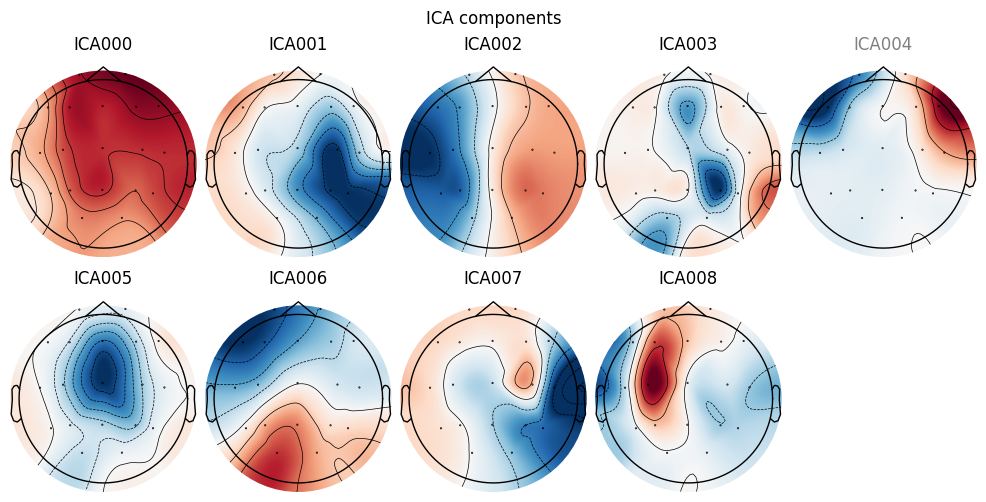

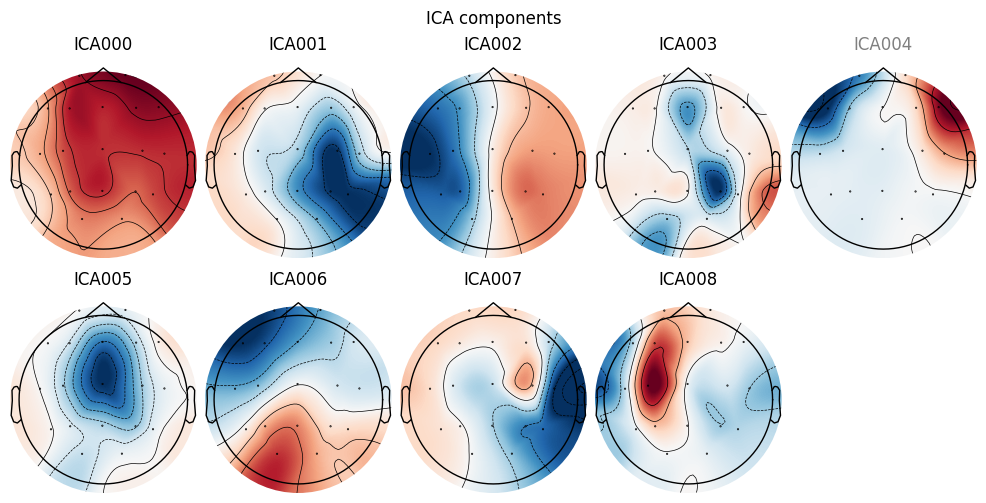

In [34]:
# Plot the ICA components again
ica.plot_components()

Хоть данный метод и увеличивает качество данных, проблема состоит в том, что мы должны руками перебиреть все файлы. Для нас не особо подходит. :(

EEG channel type selected for re-referencing
Creating RawArray with float64 data, n_channels=18, n_times=18000
    Range : 0 ... 17999 =      0.000 ...    89.995 secs
Ready.
Added the following bipolar channels:
Fp1-F7, F7-T3, T3-T5, T5-O1, Fp2-F8, F8-T4, T4-T6, T6-O2, Fp1-F3, F3-C3, C3-P3, P3-O1, Fp2-F4, F4-C4, C4-P4, P4-O2, Fz-Cz, Cz-Pz


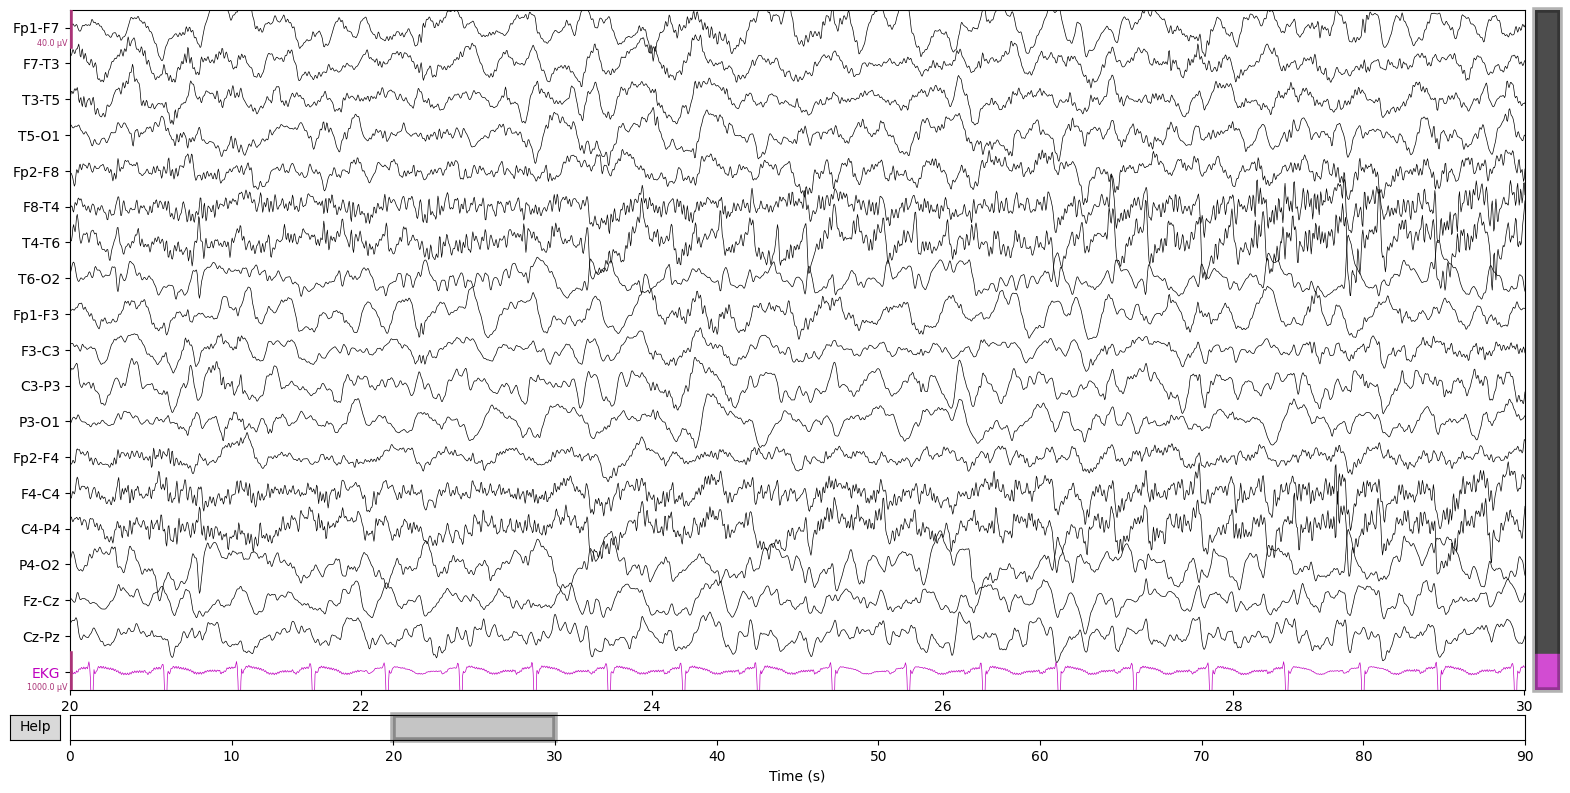

In [35]:
# Define bipolar electrode pairs for re-referencing
bipolar = [
    ['Fp1', 'F7'], ['F7', 'T3'], ['T3', 'T5'], ['T5', 'O1'],    # Left Temporal
    ['Fp2', 'F8'], ['F8', 'T4'], ['T4', 'T6'], ['T6', 'O2'],    # Right Temporal
    ['Fp1', 'F3'], ['F3', 'C3'], ['C3', 'P3'], ['P3', 'O1'],    # Left Parasagittal
    ['Fp2', 'F4'], ['F4', 'C4'], ['C4', 'P4'], ['P4', 'O2'],    # Right Parasagittal
    ['Fz', 'Cz'], ['Cz', 'Pz'],   # Central
]

# Separate the anode and cathode channels
anode, cathode = list(map(list,zip(*bipolar)))

# Create a bipolar reference for the filtered raw data
raw_bip_ref = mne.set_bipolar_reference(raw_filtered, anode=anode, cathode=cathode)
# Plot the bipolar referenced data starting at 20 seconds, with a 10-second window
raw_bip_ref.plot(start=20, duration=10)
plt.show()

In [36]:
# Convert the time 1 second to an index
raw_bip_ref.time_as_index(1)

array([200])

In [37]:
# Link to the source of the code
# Taken from https://www.kaggle.com/code/kimbyungchun/preprocess-with-mne-for-human/notebook

# Set the configuration for the raw data plot size
mne.set_config('MNE_BROWSE_RAW_SIZE','16,8')

# Define a function to load EEG data based on an ID
def load_eeg(eeg_id, data_type:Literal['train','test']='train'):
    BASE_PATH = '/kaggle/input/hms-harmful-brain-activity-classification'
    eeg_df = pd.read_parquet(f'{BASE_PATH}/{data_type}_eegs/{eeg_id}.parquet')
    return eeg_df

# Define a function to get filtered bipolar referenced EEG data
def get_filtered_bipolar(eeg_id, data_type:Literal['train','test']='train'):
    bipolar = [
        ['Fp1', 'F7'], ['F7', 'T3'], ['T3', 'T5'], ['T5', 'O1'],    # Left Temporal
        ['Fp2', 'F8'], ['F8', 'T4'], ['T4', 'T6'], ['T6', 'O2'],    # Right Temporal
        ['Fp1', 'F3'], ['F3', 'C3'], ['C3', 'P3'], ['P3', 'O1'],    # Left Parasagittal
        ['Fp2', 'F4'], ['F4', 'C4'], ['C4', 'P4'], ['P4', 'O2'],    # Right Parasagittal
        ['Fz', 'Cz'], ['Cz', 'Pz'],   # Central
    ]
    anode, cathode = list(map(list,zip(*bipolar)))
    # Load the EEG data
    eeg_df = load_eeg(eeg_id, data_type)
    
    # Create an MNE info object
    info = mne.create_info(
        eeg_df.columns.to_list(),
        ch_types=(["eeg"]*(len(eeg_df.columns)-1))+['ecg'],
        sfreq=200
    )

    # Set the montage to the standard 10-20 system
    info.set_montage("standard_1020")

    # Create a raw MNE object with the EEG data, convert µV to V and apply filters
    raw = mne.io.RawArray(
        eeg_df.to_numpy().T*1e-6,    # µV to V
        info
    ).filter(l_freq=1, h_freq=70,).notch_filter(60, picks='eeg')

    # Return the bipolar referenced raw data
    return mne.set_bipolar_reference(raw, anode=anode, cathode=cathode)

# Define a function to get and plot bipolar referenced EEG data
def bipolar(eeg_id, offset=0., duration=10.0, data_type:Literal['train','test']='train', plot=True):
    # Get the filtered bipolar referenced EEG data
    bip_ref = get_filtered_bipolar(eeg_id, data_type)
    
    # Define the start time for the plot
    start = 25.0 + offset - duration/2
    if plot:
        # Plot the bipolar referenced data
        bip_ref.plot(start=start, duration=duration)
    
     # Convert start and stop times to indices
    start_idx = bip_ref.time_as_index(start).item()
    stop_idx = bip_ref.time_as_index(start + duration).item()
    # Return the data for the specified time window
    return bip_ref.get_data(start=start_idx, stop=stop_idx)

Creating RawArray with float64 data, n_channels=20, n_times=18000
    Range : 0 ... 17999 =      0.000 ...    89.995 secs
Ready.
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 70 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 70.00 Hz
- Upper transition bandwidth: 17.50 Hz (-6 dB cutoff frequency: 78.75 Hz)
- Filter length: 661 samples (3.305 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenu

[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.0s


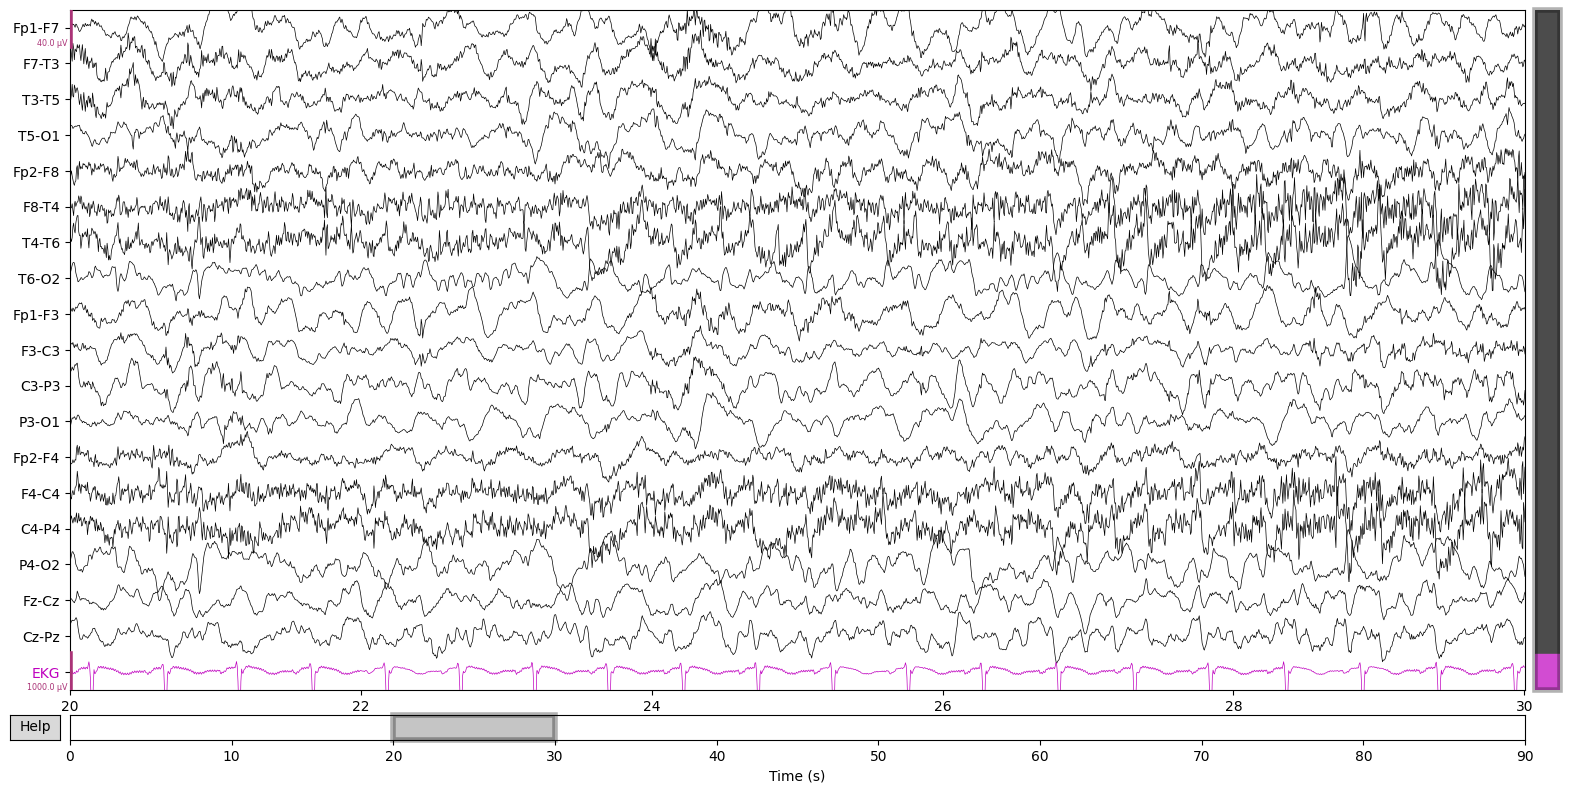

(19, 2000)

In [42]:
#exhample
data = bipolar(1628180742, 0, 10)
data.shape

Хоть данные и становятся чище, мы все нарушаем изначальную структуру данных из-за чего быстрое применение и тестироване моделей может оказатся затруднительно. тем не менее она может быть использована для преобразования данных непосредственно перед передачей в модель

# linear denoise

In [55]:
# Define constants for EEG sampling time, rate, and duration
eeg_sampling_time = 50  # seconds
eeg_sampling_rate = 200 # Hz
eeg_duration = eeg_sampling_rate * eeg_sampling_time
n_interactive = 100

In [57]:
# Function to plot EEG data
def plot_eeg(df, moving_avg=1):
    # Create a figure with 20 subplots arranged in a single column, sharing the x-axis
    fig, axs = plt.subplots(20, 1, figsize=(30, 15), sharex=True)
    # Loop through each subplot (one for each channel)
    for i, ax in enumerate(axs):
        # Plot the data of the i-th column (channel) in the DataFrame
        ax.plot(df.iloc[:,i], color="black")
        # Plot vertical red lines at the indices where there are missing values
        for vline in df[df.iloc[:,i].isna()].index:
            # Determine the minimum and maximum values of the current channel for plotting the vertical lines
            line_min = df.iloc[:,i].min()
            line_max = df.iloc[:,i].max()
            ax.vlines(vline, line_min, line_max, color='red')
        
        ax.set_ylabel(df.columns[i], rotation=0)
        ax.set_yticklabels([])
        ax.set_yticks([])
        ax.set_xticks([])
        ax.spines[["top", "bottom", "left", "right"]].set_visible(False)

# Function to get training EEG data based on a query dictionary
def get_train_eeg(q:dict) -> pd.DataFrame:
    parquet_df = pd.read_parquet(path/"train_eegs"/f"train_eegs/{q['eeg_id']}.parquet")
    eeg_start_index = int(EEG_SAMPLING_RATE * q["eeg_label_offset_seconds"])
    return parquet_df.iloc[eeg_start_index:eeg_start_index+EEG_DURATION]

# Function to denoise EEG data using wavelet decomposition
def denoise(x, wavelet='db8', level=1): # dmey for seizure patient denoise, db8 for healthy patient denoise
    # paper: https://jart.icat.unam.mx/index.php/jart/article/view/339/336

    # Helper function to compute the mean absolute deviation
    def _maddest(d, axis=None):
        return np.mean(np.absolute(d - np.mean(d, axis)), axis)
    
    # Initialize a dictionary to store the denoised data
    ret = {key:[] for key in x.columns}

    # Loop through each column (channel) in the DataFrame
    for pos in x.columns:
        # Perform wavelet decomposition on the current channel data
        coeff = pywt.wavedec(x[pos], wavelet, mode="per")
        # Estimate the noise level using the mean absolute deviation of the detail coefficients
        sigma = (1/0.6745) * _maddest(coeff[-level])
        # Calculate the universal threshold
        uthresh = sigma * np.sqrt(2*np.log(len(x)))
        # Apply hard thresholding to the detail coefficients
        coeff[1:] = (pywt.threshold(i, value=uthresh, mode='hard') for i in coeff[1:])
        # Reconstruct the signal from the thresholded coefficients
        ret[pos]=pywt.waverec(coeff, wavelet, mode='per')
    return pd.DataFrame(ret)

# Function to interpolate missing values in the data
def interpolate(raw_df):
    df = raw_df.copy()
    df = df.interpolate(
        method='linear',
        axis=0,
        limit=1, # ref to 1 value
        limit_direction="both", # interpolate from pre and post values
        limit_area='inside',
    )
    return df

# Function to replace outliers in a series with clipped values
def replace_outlier(series, bias=1.5, upper=0.95, lower=0.05):
    lower_clip = series.quantile(lower)
    upper_clip = series.quantile(upper)
    iqr = upper_clip - lower_clip
    
    outlier_min = lower_clip - (iqr) * bias
    outlier_max = upper_clip + (iqr) * bias

    series = series.clip(outlier_min, outlier_max)
    return series

In [62]:
# Define base directory and related constants
BASE_DIR = Path("/kaggle/input/hms-harmful-brain-activity-classification")
TRAIN_EEG_DIR = BASE_DIR/"train_eegs"
WAVELET_DECOMPOSITION_TREE_LEVEL = 1
WAVELET_TYPE = "dmey"

# Load the training DataFrame and list of EEG files
train_df = pd.read_csv(BASE_DIR/"train.csv")
eeg_list = glob.glob(str(TRAIN_EEG_DIR/"*.parquet"))
if True or os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Interactive':
    print("Running on development environment")
#     train_df = train_df.sample(N_INTERACTIVE)
    eeg_list = eeg_list[:N_INTERACTIVE]
elif os.environ.get('KAGGLE_KERNEL_RUN_TYPE','') == 'Batch':
    print("Running on production environment")

Running on development environment


https://www.kaggle.com/datasets/nakagawaren0805/hms-preprocessed-dataset can be used as new input

In [63]:
# Create directory for preprocessed EEGs
preprocessed_eeg_dir = "train_eegs"
os.makedirs(preprocessed_eeg_dir, exist_ok=True)

# Initialize variables to keep track of ignored EEGs
ignore_parquet_num = 0
ignore_parquet_eeg_ids = list()

# Process each EEG file in the list
for p_eeg in eeg_list:
    eeg_id = int(p_eeg.split("/")[-1].split(".")[0])
    eeg = pd.read_parquet(p_eeg)
    eeg = interpolate(eeg)
    if eeg.isna().sum().sum(): # discard EEG(still contail missing value)
        ignore_parquet_num+=1
        ignore_parquet_eeg_ids.append(eeg_id)
        continue
    eeg = denoise(eeg, wavelet=WAVELET_TYPE)
    eeg.to_parquet(os.path.join(preprocessed_eeg_dir, f"{eeg_id}.parquet"))
print(f"{ignore_parquet_num=}/{len(eeg_list)}")

ignore_parquet_num=1/100


In [64]:
# Save the preprocessed training DataFrame
preprocessed_traindf = train_df.loc[~train_df["eeg_id"].isin(ignore_parquet_eeg_ids)].copy()
preprocessed_traindf.to_csv("train.csv")